# 1. Data Loading and Preprocessing
In this section, we load the Pima Indians Diabetes dataset and split it into two main parts:

Features (X) and Target (y), where X includes all the features excluding the target variable 'Outcome', and y is the target variable indicating whether the patient has diabetes (1) or not (0).
Standardizing the data ensures that the features are on the same scale, which helps improve the performance of machine learning models.
The dataset is then split into training (80%) and test (20%) sets using train_test_split.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv('./data/diabetes.csv')

# Split the features (X) and target label (y)
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training (80%) and testing (20%) sets
X_train_all, X_test, y_train_all, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print('training data has %d observation with %d features'% X_train_all.shape)
print('test data has %d observation with %d features'% X_test.shape)

DEBUG:matplotlib:matplotlib data path: c:\Users\20193599\Documents\MASTER\YEAR 2\Q1\Research Project\RTDM\.venv\Lib\site-packages\matplotlib\mpl-data
DEBUG:matplotlib:CONFIGDIR=C:\Users\20193599\.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is win32
DEBUG:matplotlib:CACHEDIR=C:\Users\20193599\.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from C:\Users\20193599\.matplotlib\fontlist-v390.json


training data has 614 observation with 8 features
test data has 154 observation with 8 features


# 2. Standard Random Forest Model Training
Here, we train a standard Random Forest classifier on the full training set. The accuracy of the model on the test set is computed and printed. The result shows an accuracy of 0.7273 for the standard Random Forest model. This serves as a baseline performance to compare against the active learning approach later.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the Random Forest classifier
rf_standard = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the entire training set (standard approach)
rf_standard.fit(X_train_all, y_train_all)

# Predict on the test set
y_test_pred_standard = rf_standard.predict(X_test)

# Calculate the accuracy of the standard Random Forest
accuracy_standard = accuracy_score(y_test, y_test_pred_standard)
print(f"Random Forest Test Accuracy (Standard Training): {accuracy_standard:.4f}")


Random Forest Test Accuracy (Standard Training): 0.7273


# 3. Active Learning with Random Forest
This section demonstrates the active learning process. Initially, only 5 samples are labeled, and the rest are left unlabeled. We then perform 10 iterations of active learning:

In each iteration, the model is trained on the labeled set, and its performance on the test set is evaluated.
The model predicts probabilities for the unlabeled set, identifying the samples with the highest uncertainty (lowest confidence) and adds them to the labeled set for the next iteration.
The process continues, with the total number of labeled samples increasing by 10 in each iteration.
From the results, we observe that the accuracy improves progressively with each iteration, reaching a final accuracy of 0.7403 after 10 iterations.

In [16]:
# Initialize a small labeled set (only 5 samples), the rest as the unlabeled set
initial_train_size = 5
X_train_labeled = X_train_all[:initial_train_size]
y_train_labeled = y_train_all[:initial_train_size]

X_train_unlabeled = X_train_all[initial_train_size:]
y_train_unlabeled = y_train_all[initial_train_size:]

# Convert y_train_unlabeled to NumPy array to avoid indexing issues
y_train_unlabeled = np.array(y_train_unlabeled)

# Define the number of samples to add in each iteration
n_samples_to_add = 10
total_samples_used = initial_train_size  # Initialize with the size of the initial labeled set

# Initialize Random Forest classifier for Active Learning
rf_active = RandomForestClassifier(n_estimators=100, random_state=42)

# Store accuracies from each iteration for plotting
active_learning_accuracies = []

# Active Learning iterations
for iteration in range(10):  # 10 iterations
    # Train the model on the labeled set
    rf_active.fit(X_train_labeled, y_train_labeled)

    # Validate on the test set
    y_test_pred_active = rf_active.predict(X_test)
    accuracy_active = accuracy_score(y_test, y_test_pred_active)
    active_learning_accuracies.append(accuracy_active)
    
    print(f"Iteration {iteration + 1}: Active Learning Test Accuracy = {accuracy_active:.4f}")

    # Predict on the unlabeled set, get the predicted probabilities
    probabilities = rf_active.predict_proba(X_train_unlabeled)
    
    # Calculate the maximum probability -- the model's most uncertain predictions
    confidence = np.max(probabilities, axis=1)
    
    # Find the most uncertain samples (with the lowest probability) and add them to the labeled set
    least_confident_indices = np.argsort(confidence)[:n_samples_to_add]
    
    # Add the most uncertain samples from the unlabeled set to the labeled set
    X_train_labeled = np.vstack((X_train_labeled, X_train_unlabeled[least_confident_indices]))
    y_train_labeled = np.concatenate((y_train_labeled, y_train_unlabeled[least_confident_indices]))

    # Remove these samples from the unlabeled set
    X_train_unlabeled = np.delete(X_train_unlabeled, least_confident_indices, axis=0)
    y_train_unlabeled = np.delete(y_train_unlabeled, least_confident_indices, axis=0)

    # Update the total number of samples used
    total_samples_used += n_samples_to_add

# Final validation on the test set
final_accuracy_active = accuracy_score(y_test, rf_active.predict(X_test))
print(f"Final Active Learning Test Accuracy: {final_accuracy_active:.4f}")

# Display the total number of samples used in Active Learning
print(f"Total samples used in Active Learning: {total_samples_used}")


Iteration 1: Active Learning Test Accuracy = 0.5390
Iteration 2: Active Learning Test Accuracy = 0.6818
Iteration 3: Active Learning Test Accuracy = 0.7013
Iteration 4: Active Learning Test Accuracy = 0.7532
Iteration 5: Active Learning Test Accuracy = 0.7403
Iteration 6: Active Learning Test Accuracy = 0.7857
Iteration 7: Active Learning Test Accuracy = 0.7727
Iteration 8: Active Learning Test Accuracy = 0.7597
Iteration 9: Active Learning Test Accuracy = 0.7727
Iteration 10: Active Learning Test Accuracy = 0.7403
Final Active Learning Test Accuracy: 0.7403
Total samples used in Active Learning: 105


# 4. Visualization of Accuracy Comparison
This section visualizes the accuracy comparison between the standard Random Forest model and the active learning model across multiple iterations. The plot demonstrates a noticeable improvement in accuracy with active learning, particularly in the first 6 iterations. After 10 iterations, using a total of 105 samples, the active learning model stabilizes around an accuracy of 0.74. In contrast, the standard Random Forest model's accuracy remains constant, using the entire labeled dataset of 614 samples. The plot also annotates the number of samples used at each iteration of active learning, and the total number of samples used by the end of the active learning process is displayed.

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\20193599\\Documents\\MASTER\\YEAR 2\\Q1\\Research Project\\RTDM\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\20193599\\Documents\\MASTER\\YEAR 2\\Q1\\Research Project\\RTDM\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.

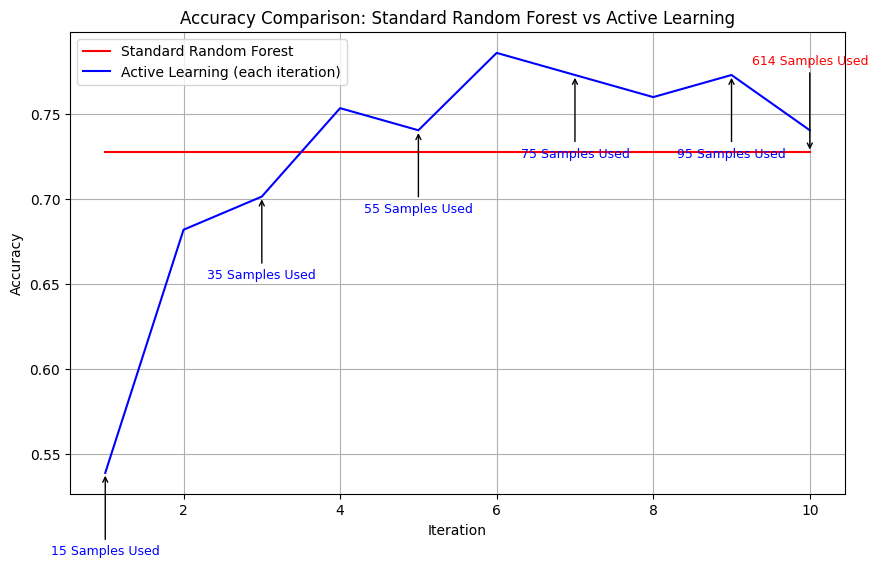

In [17]:
# Plot the accuracy comparison between Standard Random Forest and Active Learning
plt.figure(figsize=(10, 6))

# Create a list of length 10 with all values as accuracy_standard to match the length of active_learning_accuracies
standard_accuracy_line = [accuracy_standard] * len(active_learning_accuracies)

# Plot the standard Random Forest accuracy using a red solid line
plt.plot(range(1, len(active_learning_accuracies) + 1), standard_accuracy_line, 'r', label="Standard Random Forest")

# Plot the accuracy of Active Learning after each iteration using a blue line
plt.plot(range(1, len(active_learning_accuracies) + 1), active_learning_accuracies, 'b', label="Active Learning (each iteration)")

# Annotate the sample usage at each iteration
for i in range(0, len(active_learning_accuracies), 2):  # Show sample usage every two iterations to avoid clutter
    total_samples = initial_train_size + (i + 1) * n_samples_to_add  # Number of samples added in each iteration
    plt.annotate(f'{total_samples} Samples Used', 
                 xy=(i + 1, active_learning_accuracies[i]), 
                 xytext=(i + 1, active_learning_accuracies[i] - 0.05),  # Adjust text position to avoid overlap
                 arrowprops=dict(facecolor='blue', arrowstyle="->"),
                 fontsize=9, 
                 verticalalignment='bottom', 
                 horizontalalignment='center', 
                 color='blue')  # Set the text color to blue

# Annotate the total samples used by the Standard Random Forest (fixed to the full training set size)
plt.annotate(f'{len(X_train_all)} Samples Used', 
             xy=(len(active_learning_accuracies), accuracy_standard), 
             xytext=(len(active_learning_accuracies), accuracy_standard + 0.05),  # Adjust text position
             arrowprops=dict(facecolor='red', arrowstyle="->"),
             fontsize=9, 
             verticalalignment='bottom', 
             horizontalalignment='center', 
             color='red')  # Set the text color to red

# Add labels and title to the plot
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: Standard Random Forest vs Active Learning")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


# 5. Summary for Active Learning Part
he standard Random Forest classifier achieved an accuracy of 0.7273 on the test set when trained using the full dataset. However, the active learning approach showed significant improvement in accuracy over time. Initially, with just 5 labeled samples, the accuracy started at 0.5390 but progressively improved with each iteration. By the 10th iteration, the accuracy reached 0.7403.

Active learning enabled the model to strategically select and add the most uncertain samples to the training set, resulting in enhanced performance. By the end of the process, the model utilized a total of 105 labeled samples, demonstrating the efficiency of active learning in improving model accuracy with fewer labeled data.

# 6. Defining Beamsearch
Here we will define our implementation of beamsearch that orrectly deals with overlapping subgroups.

In [18]:
import logging
import numpy as np
import pandas as pd
from typing import Union
import random

In [36]:

# Adjust logging level if needed
# logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.WARNING)


In [20]:
# Set random seed for reproducibility
random.seed(42)

In [21]:
class Description:

    def __init__(
        self, attribute: str = None, value: Union[str, float, int, bool, list] = None
    ):
        self.description = {}
        if attribute is not None:
            self.description[attribute] = value

    def __contains__(self, col):
        return col in self.description

    def extend(self, attribute, value):
        self.description[attribute] = value
        return self

    def decrypt(self, translation):
        for key, value in self.description.items():
            if key in translation:
                self.description[key] = translation[key][value]

    def get_mask(self, df):
        if not self.description:
            return pd.Series([True] * len(df), index=df.index)
        mask = pd.Series([True] * len(df), index=df.index)
        for attribute, value in self.description.items():
            if isinstance(value, list) and len(value) == 2:
                # Apply range condition
                mask &= (df[attribute] > value[0]) & (df[attribute] <= value[1])
            else:
                # Apply equality condition
                mask &= df[attribute] == value
        return mask

    def __str__(self):
        if not self.description:
            return "all"
        else:
            result = []
            for key, value in self.description.items():
                if isinstance(value, list) and len(value) == 2:
                    result.append(f"{value[0]:.2f} < {key} ≤ {value[1]:.2f}")
                else:
                    result.append(f"{key} = {value}")
            return " AND ".join(result)

In [22]:
class Subgroup:

    def __init__(self, data: pd.DataFrame, description: Description):
        self.data = data
        self.description = description
        self.score = None
        self.coverage = None

    @classmethod
    def create(cls, df: pd.DataFrame, description: Description):
        mask = description.get_mask(df)
        data = df[mask]
        return cls(data, description)

    def evaluate_quality(
        self, overall_stats: dict, quality_measure_func, min_size, target
    ):
        if self.size < min_size:
            self.score = -np.inf  # Esclude sottogruppi troppo piccoli
        else:
            self.score = quality_measure_func(self.data, overall_stats, target)

    def decrypt_description(self, translation):
        self.description.decrypt(translation)

    @property
    def size(self):
        return len(self.data)

    def print(self):
        logging.debug(f"{str(self.description)} {self.score} ({self.size})")


In [6]:
class Beam:

    def __init__(self, settings: dict):
        self.subgroups = []
        self.candidates = []
        self.max_items = settings["width"]
        self.candidate_size = int(
            settings.get("candidate_size", settings["width"] ** 2)
        )
        self.strategy = settings["strategy"]
        self.min_score = None
        self.scores = []

    def add(self, subgroup: Subgroup):
        if subgroup.score == -np.inf:
            return  # Skip subgroups with invalid scores

        if len(self.candidates) < self.candidate_size:
            self.candidates.append(subgroup)
            self.scores.append(subgroup.score)
            self.min_score = (
                min(self.scores) if self.strategy == "maximize" else max(self.scores)
            )
        elif (self.strategy == "maximize" and subgroup.score > self.min_score) or (
            self.strategy == "minimize" and subgroup.score < self.min_score
        ):
            idx = self.scores.index(self.min_score)
            del self.scores[idx]
            del self.candidates[idx]
            self.candidates.append(subgroup)
            self.scores.append(subgroup.score)
            self.min_score = (
                min(self.scores) if self.strategy == "maximize" else max(self.scores)
            )

    def sort(self, attribute: str = "score") -> None:
        if attribute == "score":
            self.candidates.sort(
                key=lambda x: x.score, reverse=(self.strategy == "maximize")
            )
            self.subgroups.sort(
                key=lambda x: x.score, reverse=(self.strategy == "maximize")
            )
        elif attribute == "coverage":
            self.candidates.sort(
                key=lambda x: x.score * x.coverage,
                reverse=(self.strategy == "maximize"),
            )
        else:
            raise ValueError("Invalid sort attribute")

    def select_cover_based(self):
        self.sort()
        if len(self.candidates) > self.max_items:
            index = np.array([], dtype=int)
            for subgroup in self.candidates:
                overlap_size = np.intersect1d(subgroup.data.index.values, index).size
                if subgroup.data.index.size == 0:
                    subgroup.coverage = 0
                else:
                    subgroup.coverage = 1 - (overlap_size / subgroup.data.index.size)
                index = np.unique(np.concatenate((index, subgroup.data.index.values)))
            self.sort(attribute="coverage")
        self.subgroups = self.candidates[: self.max_items]
        self.scores = [s.score for s in self.subgroups]
        self.min_score = (
            min(self.scores) if self.strategy == "maximize" else max(self.scores)
        )

    def decrypt_descriptions(self, translation):
        for s in self.subgroups:
            s.decrypt_description(translation)

    def print(self):
        self.sort(attribute="coverage")
        logging.debug("-" * 20)
        for s in self.subgroups:
            s.print()

In [23]:
# Quality Measures


def mean_uncertainty_deviation(
    subgroup_data: pd.DataFrame, overall_stats: dict, target: str
) -> float:
    subgroup_mean = subgroup_data[target].mean()
    return subgroup_mean - overall_stats["mean"]


def z_score_uncertainty(
    subgroup_data: pd.DataFrame, overall_stats: dict, target: str
) -> float:
    subgroup_mean = subgroup_data[target].mean()
    subgroup_std = subgroup_data[target].std()
    subgroup_stderr = subgroup_std / np.sqrt(len(subgroup_data))
    if subgroup_std == 0:
        return 0
    return (subgroup_mean - overall_stats["mean"]) / subgroup_stderr

#use new entropy formula
def calculate_entropy(values, num_bins=4):
    counts, _ = np.histogram(values, bins=num_bins)
    probabilities = counts / counts.sum()
    probabilities = probabilities[probabilities > 0]  # Avoid log(0)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy


def wracc_uncertainty(
    subgroup_data: pd.DataFrame, overall_stats: dict, target: str
) -> float:
    p = len(subgroup_data) / overall_stats["total_count"]
    subgroup_mean = subgroup_data[target].mean()
    entropy_weight = calculate_entropy(
        subgroup_data[target], num_bins=overall_stats["num_bins"]
    )
    entropy_ratio = (
        entropy_weight / overall_stats["entropy"]
        if overall_stats["entropy"] != 0
        else 1
    )
    return p * (subgroup_mean - overall_stats["mean"]) * entropy_ratio

In [24]:
def expand_description(
    description: Description, df: pd.DataFrame, target: str, num_bins=4
):
    new_descriptions = []
    used_attributes = set(description.description.keys())
    for attribute in df.columns:
        if attribute in used_attributes or attribute == target:
            continue
        if pd.api.types.is_numeric_dtype(df[attribute]):
            # For numerical attributes, create bins
            # bins = np.linspace(df[attribute].min(), df[attribute].max(), num_bins + 1)
            bins = np.quantile(df[attribute].dropna(), np.linspace(0, 1, num_bins + 1))
            for i in range(len(bins) - 1):
                bin_range = [bins[i], bins[i + 1]]
                new_desc = Description()
                new_desc.description = description.description.copy()
                new_desc.extend(attribute, bin_range)
                new_descriptions.append(new_desc)
        else:
            # For categorical attributes, use unique values
            unique_values = df[attribute].unique()
            for value in unique_values:
                new_desc = Description()
                new_desc.description = description.description.copy()
                new_desc.extend(attribute, value)
                new_descriptions.append(new_desc)
    return new_descriptions

In [25]:
def beam_search(df: pd.DataFrame, settings: dict):

    if "target" not in settings:
        raise ValueError("Target attribute not specified in settings")

    target = settings["target"]

    # If settings have attributes key, filter the dataframe
    if "attributes" in settings:
        df = df[settings["attributes"] + [target]]

    overall_mean = df[target].mean()
    overall_std = df[target].std()
    overall_entropy = calculate_entropy(
        df[target], num_bins=settings.get("num_bins", 4)
    )
    overall_stats = {
        "mean": overall_mean,
        "std": overall_std,
        "entropy": overall_entropy,
        "total_count": len(df),
        "num_bins": settings.get("num_bins", 4),
    }

    # Select the quality measure function
    quality_measure_name = settings.get("quality_measure", "mean_uncertainty_deviation")
    if quality_measure_name == "mean_uncertainty_deviation":
        quality_measure_func = mean_uncertainty_deviation
    elif quality_measure_name == "z_score_uncertainty":
        quality_measure_func = z_score_uncertainty
    elif quality_measure_name == "wracc_uncertainty":
        quality_measure_func = wracc_uncertainty
    else:
        raise ValueError(f"Unknown quality measure: {quality_measure_name}")

    initial_description = Description()
    initial_subgroup = Subgroup.create(df, initial_description)
    initial_subgroup.evaluate_quality(
        overall_stats, quality_measure_func, settings.get("min_size", 1), target
    )

    beam = Beam(settings)
    beam.add(initial_subgroup)

    max_depth = settings.get("max_depth", 3)
    for depth in range(max_depth):
        logging.debug(f"Depth {depth+1}")
        for subgroup in beam.subgroups:
            expanded_descriptions = expand_description(
                subgroup.description, df, target, num_bins=settings.get("num_bins", 4)
            )
            for description in expanded_descriptions:
                new_subgroup = Subgroup.create(df, description)
                new_subgroup.evaluate_quality(
                    overall_stats,
                    quality_measure_func,
                    settings.get("min_size", 1),
                    target,
                )
                beam.add(new_subgroup)
        beam.select_cover_based()

    beam.print()
    return beam.subgroups

In [26]:
def load_dataset():
    # Load the dataset from the CSV file
    data = pd.read_csv("data/diabetes.csv")

    # Set outcome to random probability
    data["Outcome"] = data["Outcome"].apply(lambda x: random.random())

    # Rename outcome column
    data = data.rename(columns={"Outcome": "Probability"})

    # Calculate Uncertainty
    data["Uncertainty"] = 1 - 2 * np.abs(data["Probability"] - 0.5)
    return data

In [27]:
data = load_dataset()
data.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Probability,Uncertainty
0,6,148,72,35,0,33.6,0.627,50,0.639427,0.721146
1,1,85,66,29,0,26.6,0.351,31,0.025011,0.050022
2,8,183,64,0,0,23.3,0.672,32,0.275029,0.550059
3,1,89,66,23,94,28.1,0.167,21,0.223211,0.446421
4,0,137,40,35,168,43.1,2.288,33,0.736471,0.527058


In [62]:
settings = {
    "width": 10, #max 10
    "candidate_size": 100,
    "strategy": "maximize",
    "max_depth": 3, #max 3
    "num_bins": 4,  # Number of bins for numerical attributes
    # "quality_measure": "z_score_uncertainty",  # Choose the quality measure here
    "quality_measure": "wracc_uncertainty",  # Choose the quality measure here
    # "quality_measure": "mean_uncertainty_deviation",  # Choose the quality measure here
    "min_size": 25,  # Minimum size of subgroups #make percentage 
    "target": "Uncertainty",  # Target attribute for quality measure
    "attributes": [
        "Pregnancies",
        "Glucose",
        "BloodPressure",
        "SkinThickness",
        "Insulin",
        "BMI",
        "DiabetesPedigreeFunction",
        "Age",
    ],
}

In [63]:

best_subgroups = beam_search(data, settings)

# Print the best subgroups
total_size = 0
for idx, sg in enumerate(best_subgroups, 1):
    print(f"Subgroup {idx}: {sg.description}")
    print(f"  Score ({settings['quality_measure']}): {sg.score}")
    print(f"  Size: {sg.size}")
    total_size += sg.size
    print()
print(total_size)

Subgroup 1: 3.00 < Pregnancies ≤ 6.00
  Score (wracc_uncertainty): 0.010465798909339944
  Size: 175

Subgroup 2: 0.00 < BMI ≤ 27.30
  Score (wracc_uncertainty): 0.008918398788255904
  Size: 183

Subgroup 3: 127.25 < Insulin ≤ 846.00
  Score (wracc_uncertainty): 0.006344449031459386
  Size: 192

Subgroup 4: 0.00 < BloodPressure ≤ 62.00
  Score (wracc_uncertainty): 0.0068074310975618415
  Size: 158

Subgroup 5: 0.24 < DiabetesPedigreeFunction ≤ 0.37 AND 117.00 < Glucose ≤ 140.25
  Score (wracc_uncertainty): 0.005741042316354878
  Size: 47

Subgroup 6: 0.24 < DiabetesPedigreeFunction ≤ 0.37
  Score (wracc_uncertainty): 0.005517998324821693
  Size: 192

Subgroup 7: 117.00 < Glucose ≤ 140.25
  Score (wracc_uncertainty): 0.0054732455192876405
  Size: 185

Subgroup 8: 32.00 < BMI ≤ 36.60 AND 0.08 < DiabetesPedigreeFunction ≤ 0.24
  Score (wracc_uncertainty): 0.003835535458585928
  Size: 46

Subgroup 9: 29.00 < Age ≤ 41.00 AND 72.00 < BloodPressure ≤ 80.00
  Score (wracc_uncertainty): 0.004290

In [39]:


# Disable all logging messages
logging.disable(logging.CRITICAL)


In [44]:
# def inverse_transform_description(description, scaler, feature_names):
#     original_description = {}
#     for feature, condition in description.items():
#         feature_index = feature_names.index(feature)
#         mean = scaler.mean_[feature_index]
#         scale = scaler.scale_[feature_index]
        
#         if isinstance(condition, list) and len(condition) == 2:
#             # Inverse transform the range
#             original_condition = [
#                 condition[0] * scale + mean,
#                 condition[1] * scale + mean
#             ]
#         else:
#             # Inverse transform the single threshold
#             original_condition = condition * scale + mean
        
#         original_description[feature] = original_condition
#     return original_description


# 7: integrating EMM with Active Learning

In [30]:
X_train_all.shape

(614, 8)

In [46]:
# Initialize a small labeled set (only 5 samples), the rest as the unlabeled set
initial_train_size = 5
X_train_labeled_emm = X_train_all[:initial_train_size]
y_train_labeled_emm = y_train_all[:initial_train_size].reset_index(drop=True)

X_train_unlabeled_emm = X_train_all[initial_train_size:]
y_train_unlabeled_emm = y_train_all[initial_train_size:].reset_index(drop=True)

# Initialize Random Forest classifier for EMM-based Active Learning
rf_emm = RandomForestClassifier(n_estimators=100, random_state=42)

# Store accuracies from each iteration for plotting
emm_learning_accuracies = []
total_samples_used_emm = initial_train_size  # Initialize with the size of the initial labeled set

# Define the number of samples to add from each subgroup
samples_per_subgroup = 2  # Adjust this value as needed

# Active Learning iterations
num_iterations = 10  # You can adjust the number of iterations
for iteration in range(num_iterations):
    # Train the model on the labeled set
    rf_emm.fit(X_train_labeled_emm, y_train_labeled_emm)
    
    # Validate on the test set
    y_test_pred_emm = rf_emm.predict(X_test)
    accuracy_emm = accuracy_score(y_test, y_test_pred_emm)
    emm_learning_accuracies.append(accuracy_emm)
    
    print(f"Iteration {iteration + 1}: EMM Active Learning Test Accuracy = {accuracy_emm:.4f}")
    
    # If there are no unlabeled samples left, break the loop
    if len(X_train_unlabeled_emm) == 0:
        print("No more unlabeled samples left.")
        break
    
    # Predict on the unlabeled set, get the predicted probabilities
    probabilities = rf_emm.predict_proba(X_train_unlabeled_emm)
    
    # Calculate the uncertainty (1 - max probability)
    uncertainty = 1 - np.max(probabilities, axis=1)
    
    # Create a dataframe with the unlabeled data and uncertainties
    data_unlabeled = pd.DataFrame(X_train_unlabeled_emm, columns=X.columns)
    data_unlabeled['Uncertainty'] = uncertainty
    data_unlabeled.reset_index(drop=True, inplace=True)  # Reset index for consistency
    
    # EMM Settings
    settings = {
        "width": 10,
        "candidate_size": 100,
        "strategy": "maximize",
        "max_depth": 3,
        "num_bins": 4,  # Number of bins for numerical attributes
        "quality_measure": "z_score_uncertainty",  # Choose the quality measure here
        # "quality_measure": "wracc_uncertainty",  # Choose the quality measure here
        # "quality_measure": "mean_uncertainty_deviation",  # Choose the quality measure here
        "min_size": 10,  # Minimum size of subgroups
        "target": "Uncertainty",  # Target attribute for quality measure
        "attributes": [
            "Pregnancies",
            "Glucose",
            "BloodPressure",
            "SkinThickness",
            "Insulin",
            "BMI",
            "DiabetesPedigreeFunction",
            "Age",
        ],
    }
    
    # Find subgroups using beam search
    best_subgroups = beam_search(data_unlabeled, settings)
    
    # From each subgroup, select samples_per_subgroup samples
    indices_to_add = []
    already_selected = set()
    samples_added_per_subgroup = {}
    for idx, subgroup in enumerate(best_subgroups, 1):
        # Get indices of the subgroup data
        subgroup_indices = subgroup.data.index.tolist()
        # Exclude samples already selected
        remaining_indices = [i for i in subgroup_indices if i not in already_selected]
        if remaining_indices:
            # Select the samples with the highest uncertainty from the remaining indices
            subgroup_uncertainties = data_unlabeled.loc[remaining_indices, 'Uncertainty']
            # Determine how many samples to select (cannot exceed subgroup size)
            samples_to_select = min(samples_per_subgroup, len(remaining_indices))
            # Get the indices of the top uncertain samples
            top_uncertainty_indices = subgroup_uncertainties.nlargest(samples_to_select).index.tolist()
            indices_to_add.extend(top_uncertainty_indices)
            # Update already selected samples
            already_selected.update(top_uncertainty_indices)
            # Keep track of samples added from this subgroup
            samples_added_per_subgroup[idx] = top_uncertainty_indices
        else:
            samples_added_per_subgroup[idx] = []
    
    if not indices_to_add:
        print("No samples selected from subgroups.")
        break
    
    # Visualize Subgroups and Samples Added
    print(f"\nIteration {iteration + 1}: Subgroups and Samples Added")
    for idx, subgroup in enumerate(best_subgroups, 1):
        # Get subgroup description
        subgroup_description = str(subgroup.description)
        # Samples added from this subgroup in this iteration
        samples_added = samples_added_per_subgroup.get(idx, [])
        # Print subgroup information
        print(f"Subgroup {idx}: {subgroup_description}")
        print(f"  Score ({settings['quality_measure']}): {subgroup.score:.4f}")
        print(f"  Subgroup Size: {subgroup.size}")
        print(f"  Samples Added: {samples_added}\n")
    
    # Add these samples to the labeled set
    X_train_labeled_emm = np.vstack((X_train_labeled_emm, X_train_unlabeled_emm[indices_to_add]))
    y_train_labeled_emm = pd.concat([y_train_labeled_emm, y_train_unlabeled_emm.iloc[indices_to_add]], ignore_index=True)
    
    # Remove these samples from the unlabeled set
    X_train_unlabeled_emm = np.delete(X_train_unlabeled_emm, indices_to_add, axis=0)
    y_train_unlabeled_emm = y_train_unlabeled_emm.drop(indices_to_add).reset_index(drop=True)
    
    # Update the total number of samples used
    total_samples_used_emm = len(X_train_labeled_emm)

Iteration 1: EMM Active Learning Test Accuracy = 0.5390

Iteration 1: Subgroups and Samples Added
Subgroup 1: -0.26 < BloodPressure ≤ 0.15 AND -1.14 < Pregnancies ≤ -0.84
  Score (z_score_uncertainty): 12.2247
  Subgroup Size: 29
  Samples Added: [117, 270]

Subgroup 2: 0.15 < BloodPressure ≤ 0.56 AND -1.04 < Age ≤ -0.79
  Score (z_score_uncertainty): 11.3649
  Subgroup Size: 21
  Samples Added: [271, 7]

Subgroup 3: -0.26 < BloodPressure ≤ 0.15 AND -0.84 < Pregnancies ≤ -0.25
  Score (z_score_uncertainty): 9.4480
  Subgroup Size: 30
  Samples Added: [12, 61]

Subgroup 4: 0.15 < BloodPressure ≤ 0.56 AND -0.84 < Pregnancies ≤ -0.25
  Score (z_score_uncertainty): 10.7902
  Subgroup Size: 30
  Samples Added: [320, 165]

Subgroup 5: 0.56 < BloodPressure ≤ 2.73 AND -1.14 < Pregnancies ≤ -0.84
  Score (z_score_uncertainty): 6.3818
  Subgroup Size: 20
  Samples Added: [151, 557]

Subgroup 6: -1.29 < SkinThickness ≤ 0.15 AND 0.15 < BloodPressure ≤ 0.56
  Score (z_score_uncertainty): 8.9906
  S

In [47]:
# Final validation on the test set
final_accuracy_emm = accuracy_score(y_test, rf_emm.predict(X_test))
print(f"Final EMM Active Learning Test Accuracy: {final_accuracy_emm:.4f}")

# Display the total number of samples used in EMM Active Learning
print(f"Total samples used in EMM Active Learning: {total_samples_used_emm}")


Final EMM Active Learning Test Accuracy: 0.7532
Total samples used in EMM Active Learning: 205


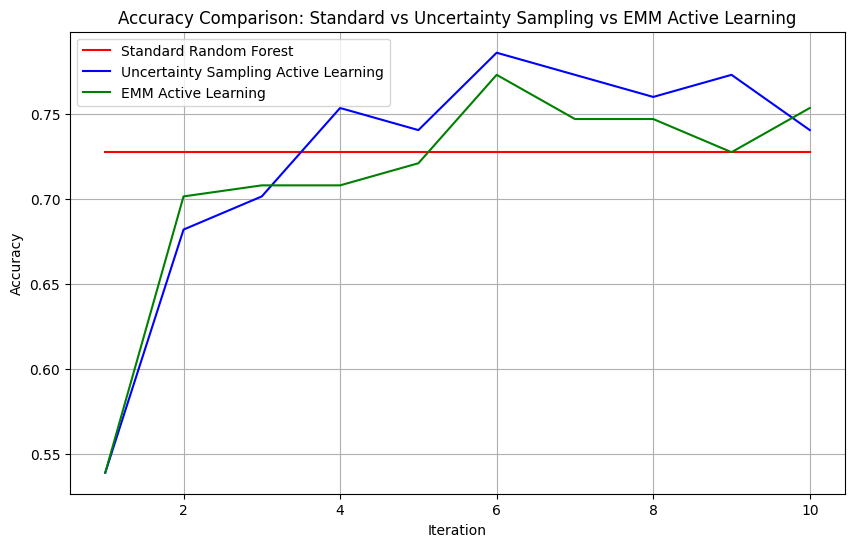

In [48]:
# Number of iterations for plotting
iterations = range(1, len(emm_learning_accuracies) + 1)

# Create a list of standard Random Forest accuracy to match the length of iterations
standard_accuracy_line = [accuracy_standard] * len(iterations)

# Ensure active_learning_accuracies has the same length for fair comparison
active_learning_accuracies_trimmed = active_learning_accuracies[:len(iterations)]

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot the standard Random Forest accuracy
plt.plot(iterations, standard_accuracy_line, 'r', label="Standard Random Forest")

# Plot the accuracy of Uncertainty Sampling Active Learning
plt.plot(iterations, active_learning_accuracies_trimmed, 'b', label="Uncertainty Sampling Active Learning")

# Plot the accuracy of EMM Active Learning
plt.plot(iterations, emm_learning_accuracies, 'g', label="EMM Active Learning")

# Add labels and title to the plot
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: Standard vs Uncertainty Sampling vs EMM Active Learning")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


# Comparing different settings

In [57]:
# Define configurations to compare
configurations = [
    {"samples_per_subgroup": 1, "quality_measure": "mean_uncertainty_deviation"},
    {"samples_per_subgroup": 2, "quality_measure": "mean_uncertainty_deviation"},
    {"samples_per_subgroup": 1, "quality_measure": "z_score_uncertainty"},
    {"samples_per_subgroup": 2, "quality_measure": "z_score_uncertainty"},
]

# Number of iterations
num_iterations = 10

# Dictionary to store results
results = {}

for config in configurations:
    print(f"\nRunning configuration: Samples per Subgroup = {config['samples_per_subgroup']}, Quality Measure = {config['quality_measure']}")
    
    # Reinitialize labeled and unlabeled sets
    X_train_labeled_emm = X_train_all[:initial_train_size]
    y_train_labeled_emm = y_train_all[:initial_train_size].reset_index(drop=True)
    
    X_train_unlabeled_emm = X_train_all[initial_train_size:]
    y_train_unlabeled_emm = y_train_all[initial_train_size:].reset_index(drop=True)
    
    # Initialize classifier
    rf_emm = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Store accuracies
    accuracies = []
    
    # Active Learning Loop
    for iteration in range(num_iterations):
        # Train the model
        rf_emm.fit(X_train_labeled_emm, y_train_labeled_emm)
        
        # Validate on the test set
        y_test_pred_emm = rf_emm.predict(X_test)
        accuracy_emm = accuracy_score(y_test, y_test_pred_emm)
        accuracies.append(accuracy_emm)
        
        # If no unlabeled samples left, break
        if len(X_train_unlabeled_emm) == 0:
            break
        
        # Predict on unlabeled set
        probabilities = rf_emm.predict_proba(X_train_unlabeled_emm)
        uncertainty = 1 - np.max(probabilities, axis=1)
        
        # Prepare data for EMM
        data_unlabeled = pd.DataFrame(X_train_unlabeled_emm, columns=X.columns)
        data_unlabeled['Uncertainty'] = uncertainty
        data_unlabeled.reset_index(drop=True, inplace=True)
        
        # EMM Settings
        settings = {
            "width": 5,
            "candidate_size": 50,
            "strategy": "maximize",
            "max_depth": 2,
            "num_bins": 4,
            "quality_measure": config['quality_measure'],
            "min_size": 5,
            "target": "Uncertainty",
            "attributes": X.columns.tolist(),
        }
        
        # Beam Search
        best_subgroups = beam_search(data_unlabeled, settings)
        
        # Number of samples to add per subgroup
        samples_per_subgroup = config['samples_per_subgroup']
        
        # Select samples
        indices_to_add = []
        for subgroup in best_subgroups:
            subgroup_indices = subgroup.data.index.tolist()
            if subgroup_indices:
                samples_to_select = min(samples_per_subgroup, len(subgroup_indices))
                subgroup_uncertainties = data_unlabeled.loc[subgroup_indices, 'Uncertainty']
                top_uncertainty_indices = subgroup_uncertainties.nlargest(samples_to_select).index.tolist()
                indices_to_add.extend(top_uncertainty_indices)
        
        indices_to_add = list(set(indices_to_add))
        
        if not indices_to_add:
            break
        
        # Add samples to labeled set
        X_train_labeled_emm = np.vstack((X_train_labeled_emm, X_train_unlabeled_emm[indices_to_add]))
        y_train_labeled_emm = pd.concat([y_train_labeled_emm, y_train_unlabeled_emm.iloc[indices_to_add]], ignore_index=True)
        
        # Remove samples from unlabeled set
        X_train_unlabeled_emm = np.delete(X_train_unlabeled_emm, indices_to_add, axis=0)
        y_train_unlabeled_emm = y_train_unlabeled_emm.drop(indices_to_add).reset_index(drop=True)
    
    # Store results
    key = f"Samples:{config['samples_per_subgroup']}_QM:{config['quality_measure']}"
    results[key] = accuracies



Running configuration: Samples per Subgroup = 1, Quality Measure = mean_uncertainty_deviation

Running configuration: Samples per Subgroup = 2, Quality Measure = mean_uncertainty_deviation

Running configuration: Samples per Subgroup = 1, Quality Measure = z_score_uncertainty

Running configuration: Samples per Subgroup = 2, Quality Measure = z_score_uncertainty


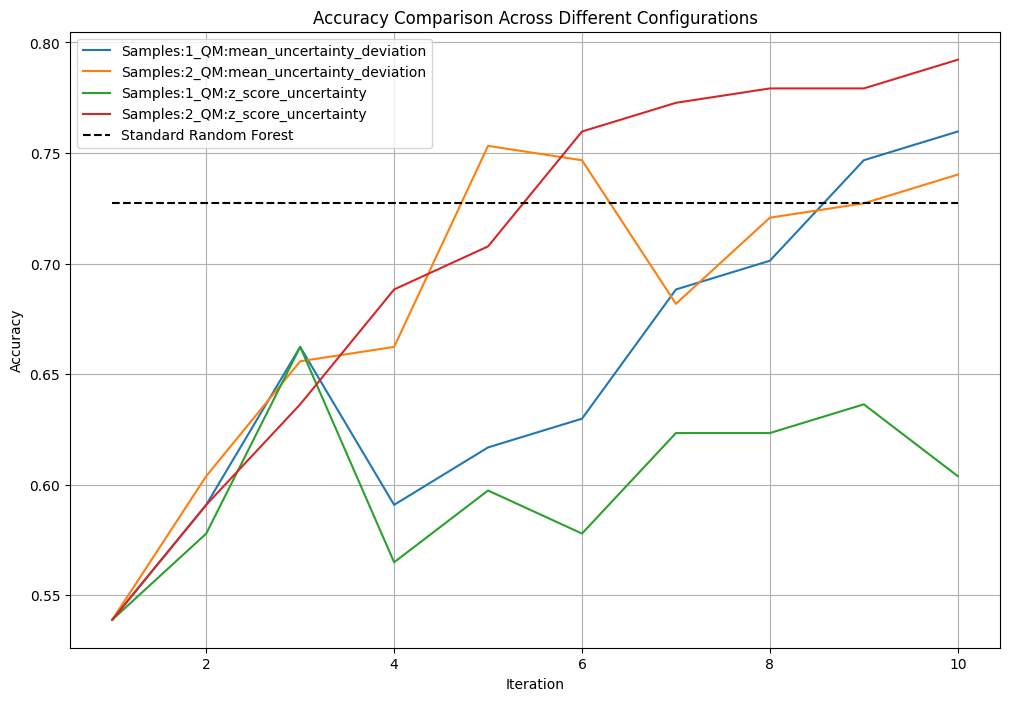

In [58]:
# Plotting the results
plt.figure(figsize=(12, 8))

for key, accuracies in results.items():
    iterations = range(1, len(accuracies) + 1)
    plt.plot(iterations, accuracies, label=key)

# Plot the standard Random Forest accuracy
standard_accuracy_line = [accuracy_standard] * num_iterations
plt.plot(range(1, num_iterations + 1), standard_accuracy_line, 'k--', label="Standard Random Forest")

plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison Across Different Configurations")
plt.legend()
plt.grid(True)
plt.show()
